In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4' 

import deepchem as dc
import pandas as pd
import pickle
import numpy as np
import warnings

from utils import *
warnings.filterwarnings('ignore')

# file = open('dicts/amino_44/amino_smiles.pickle','rb')
# amino_acids = pickle.load(file)
amino_acids = pd.read_csv('dicts/amino_44/amino_44_physics_calcs.csv')
amino_acids = amino_acids.drop(['bestgb'],axis=1)
amino_acids['null'] = 0
# amino_acids
freesolv = pd.read_csv('dicts/database.txt',sep='; ')
# freesolv['uncertainty'] = ~freesolv['text notes.'].str.contains('Experimental uncertainty not presently available, so assigned a default value')#.astype(int)+2
freesolv['uncertainty'] = ~freesolv['text notes.'].str.contains('default')
# freesolv['uncertainty'] = ~freesolv['text notes.'].str.contains('uncertainty')
freesolv.describe()

,experimental value (kcal/mol),experimental uncertainty (kcal/mol),Mobley group calculated value (GAFF) (kcal/mol),calculated uncertainty (kcal/mol)
count,642.000000,642.000000,642.000000,642.000000
mean,-3.803006,0.567352,-3.486059,0.030327
std,3.847820,0.305828,4.186344,0.009027
min,-25.470000,0.030000,-21.760000,0.010000
25%,-5.727500,0.600000,-5.425000,0.030000
50%,-3.530000,0.600000,-3.050000,0.030000
75%,-1.215000,0.600000,-0.482500,0.030000
max,3.430000,1.930000,3.330000,0.090000


In [34]:
def train_model(params, smiles, expt,b,val):
    feat = feats[params['feat']]
    part = (b, val)
    smiles = partition(smiles, part)
    expt = partition(expt, part)
    feat = partition(feat, part)
    featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
    train = dc.data.NumpyDataset(X=featurizer.featurize(smiles[0]), 
                                 y=np.array(np.array(expt[0])-np.array(feat[0])).transpose())
    model = dc.models.GraphConvModel(n_tasks=1, graph_conv_layers=params['graph_conv_layers'],
                                         mode='regression', dropout=params['dropout'], 
                                         batch_normalize=params['batch_normalize'], 
                                         batch_size=params['batch_size'], 
                                         dense_layer_size=params['dense_layer_size'])
    model.fit(train, nb_epoch=params['epochs'])
    p=()
    for i in range(len(part)):
        p += (np.array(model.predict_on_batch(featurizer.featurize(smiles[i])).flatten()),)

    p_true = {'test' : list(expt[1]), 'train' : list(expt[0])}
    p_phy = {'test' : list(feat[1]), 'train' : list(feat[0])}
    p_corr = {'test' : list(p[1] + feat[1]), 'train' : list(p[0] + feat[0])}
    return model,p_true,p_phy,p_corr

In [35]:
# FreeSolve Database
freeSolve = pickle.load(open('dicts/consol.pickle', 'rb')) 

expt, tip, smiles, gbn, igb, asc, zap, cha, bestgb,nul = [], [], [], [], [], [], [], [], [],[]
for i in freeSolve.keys():
    expt.append(freeSolve[i]['expt'])
    smiles.append(freeSolve[i]['smiles'])
    tip.append(freeSolve[i]['calc'])
    gbn.append(freeSolve[i]['gbnsr6'])
    igb.append(freeSolve[i]['igb5'])
    asc.append(freeSolve[i]['asc'])
    zap.append(freeSolve[i]['zap9'])
    cha.append(freeSolve[i]['cha'])
    bestgb.append(freeSolve[i]['bestgb'])
    nul.append(0)
feats = {'tip3p' : tip, 'gbnsr6' : gbn, 'igb5' : igb, 'asc' : asc, 
         'null' : nul, 'zap9' : zap, 'chagb' : cha,'bestgb':bestgb}
# freeSolve['mobley_2410897']

In [36]:
params = [
        {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'tip3p', 
           'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},
         # {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'gbnsr6', 
         #  'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},
         # {'epochs' : 500, 'dropout' : 0.6, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'asc', 
         #  'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},
         # {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'bestgb', 
         #  'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},
         {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'zap9', 
          'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},          
         {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'chagb', 
          'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]},
         {'epochs' : 500, 'dropout' : 0.4, 'batch_normalize' : False, 'batch_size' : 100, 'feat' : 'null', 
          'kfold' : -1, 'dense_layer_size' : 27, 'graph_conv_layers' : [32, 32]}
        ]

In [37]:
np.random.seed(10)
b = list(psuedoScramble(expt, bins=int(len(expt)/10)))

val = []
for i in range(len(b)//8):
    #j = np.random.randint(0, len(b))
    j = i*7
    val.append(b.pop(j))
np.mean(b)
len(b)

562

In [38]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)
amino_X=featurizer.featurize(amino_acids['smiles'].to_numpy())

In [39]:
%%time
import warnings
warnings.filterwarnings('ignore')
amino_results = amino_acids.copy()
error = 1.
for p in params:
    print(p['feat'])
    feat = p['feat']
    model,p_true,p_phy,p_corr = train_model(p,smiles,expt,b,val)
    preds = np.array(model.predict_on_batch(amino_X))
    amino_results[feat+'_ml'] = preds
    amino_results[feat+'_with_ml'] = amino_results[feat]+amino_results[feat+'_ml']
    
    print('physics model: test',np.round(rmsd(p_true['test'],p_phy['test']),3),
              'train',np.round(rmsd(p_true['train'],p_phy['train']),3))
    print('physics + ml: test',np.round(rmsd(p_true['test'],p_corr['test']),3),
              'train',np.round(rmsd(p_true['train'],p_corr['train']),3))
    print('rmsd for physics model compared to tip3p:',np.round(rmsd(amino_results['tip3p'],amino_results[feat]),3))
    print('rmsd for physics + ML compared to tip3p:',np.round(rmsd(amino_results['tip3p'],amino_results[feat+'_with_ml']),3))
    # for name,tip, p,s in zip(amino_names,amino_tip3p,mean_preds,std_preds):
    #     print(name,tip,p,'±',s)
    print()
amino_results

tip3p
physics model: test 1.435 train 1.556
physics + ml: test 1.037 train 0.72
rmsd for physics model compared to tip3p: 0.0
rmsd for physics + ML compared to tip3p: 1.15

zap9
physics model: test 1.855 train 1.64
physics + ml: test 1.452 train 0.728
rmsd for physics model compared to tip3p: 5.455
rmsd for physics + ML compared to tip3p: 4.526

chagb
physics model: test 1.315 train 1.77
physics + ml: test 1.008 train 0.782
rmsd for physics model compared to tip3p: 1.241
rmsd for physics + ML compared to tip3p: 1.513

null
physics model: test 5.45 train 5.402
physics + ml: test 1.616 train 1.125
rmsd for physics model compared to tip3p: 36.39
rmsd for physics + ML compared to tip3p: 29.8

CPU times: user 2min 19s, sys: 21.5 s, total: 2min 41s
Wall time: 1min 5s


,amino_acid,smiles,tip3p,chagb,zap9,null,tip3p_ml,tip3p_with_ml,zap9_ml,zap9_with_ml,chagb_ml,chagb_with_ml,null_ml,null_with_ml
0,ala2-abt,CNC(=O)[C@H](C)NC(C)O,-17.86,-17.6680,-13.47670,0,-1.189922,-19.049922,-2.535729,-16.012429,-1.574797,-19.242797,-7.573489,-7.573489
1,ala-abt,CNC(=O)[C@H](C)NC(C)O,-14.01,-13.4394,-10.10850,0,-1.189922,-15.199922,-2.535729,-12.644229,-1.574797,-15.014197,-7.573489,-7.573489
2,arg2-abt,CNC(=O)[C@H](CCCNC(N)=[NH2+])NC(C)O,-77.28,-79.8774,-77.95410,0,-0.564143,-77.844143,-2.852540,-80.806640,-1.436351,-81.313751,-10.893697,-10.893697
3,arg-abt,CNC(=O)[C@H](CCCNC(N)=[NH2+])NC(C)O,-60.99,-64.0845,-62.80430,0,-0.564143,-61.554143,-2.852540,-65.656840,-1.436351,-65.520851,-10.893697,-10.893697
4,ash2-abt,CNC(O)C(CC(O)O)NC(C)O,-22.03,-20.4208,-18.20280,0,-1.729322,-23.759322,-2.648345,-20.851145,-1.816108,-22.236908,-8.636249,-8.636249
5,ash-abt,CNC(O)C(CC(O)O)NC(C)O,-16.74,-16.1625,-14.24490,0,-1.729322,-18.469322,-2.648345,-16.893245,-1.816108,-17.978608,-8.636249,-8.636249
6,asn2-abt,CNC(=O)[C@H](CC(N)=O)NC(C)O,-23.38,-23.6501,-19.61220,0,-1.070418,-24.450418,-2.520731,-22.132931,-1.568449,-25.218549,-10.422838,-10.422838
7,asn-abt,CNC(=O)[C@H](CC(N)=O)NC(C)O,-20.88,-20.9514,-17.31750,0,-1.070418,-21.950418,-2.520731,-19.838231,-1.568449,-22.519849,-10.422838,-10.422838
8,asp2-abt,CNC(=O)[C@H](CC(=O)O)NC(C)O,-79.38,-78.4700,-66.46720,0,1.181670,-78.198330,-0.423239,-66.890439,-0.450878,-78.920878,-9.485277,-9.485277
9,asp-abt,CNC(=O)[C@H](CC(=O)O)NC(C)O,-77.86,-78.8793,-66.81660,0,1.181670,-76.678330,-0.423239,-67.239839,-0.450878,-79.330178,-9.485277,-9.485277


In [2]:
amino_results.to_csv('dicts/amino_44/test.csv',index=False)
# amino_results = pd.read_csv('dicts/amino_44/amino_44_ml_results.csv.csv')

NameError: name 'amino_results' is not defined

In [ ]:
# tip3p
# physics model: test 1.435 train 1.556
# physics + ml: test 1.083 train 0.735
# rmsd for physics model compared to tip3p: 0.0
# rmsd for physics + ML compared to tip3p: 1.324

# zap9
# physics model: test 1.855 train 1.64
# physics + ml: test 1.641 train 0.83
# rmsd for physics model compared to tip3p: 5.455
# rmsd for physics + ML compared to tip3p: 4.105

# chagb
# physics model: test 1.315 train 1.77
# physics + ml: test 1.088 train 0.763
# rmsd for physics model compared to tip3p: 1.241
# rmsd for physics + ML compared to tip3p: 1.543

# null
# physics model: test 5.45 train 5.402
# physics + ml: test 1.592 train 1.101
# rmsd for physics model compared to tip3p: 36.39
# rmsd for physics + ML compared to tip3p: 29.43

# CPU times: user 2min 25s, sys: 22 s, total: 2min 47s
# Wall time: 1min 8s

15 total amino acids

tip3p
physics model compared to tip3p: rmsd = 0.0
rmsd for physics + ML compared to tip3p: 1.17
zap9
physics model compared to tip3p: rmsd = 4.128
rmsd for physics + ML compared to tip3p: 2.005
chagb
physics model compared to tip3p: rmsd = 0.997
rmsd for physics + ML compared to tip3p: 1.274
null
physics model compared to tip3p: rmsd = 15.423
rmsd for physics + ML compared to tip3p: 7.528


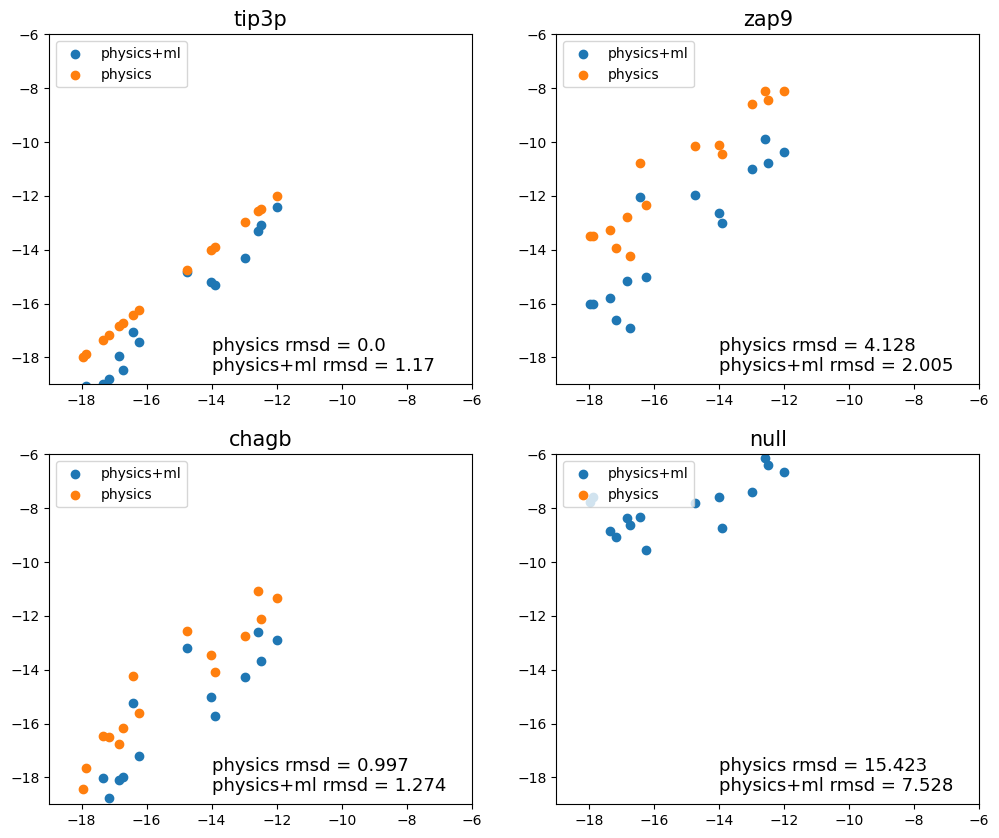

In [99]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
h = 6
f = 18
i=1
tip3p_calc = amino_results[(amino_results.tip3p > -f)]['tip3p']
print(len(tip3p_calc),'total amino acids')
print()
for p in params:
    print(p['feat'])
    feat = p['feat']
    
    phys_calc = amino_results[(amino_results.tip3p > -f)][feat]
    phys_ml = amino_results[(amino_results.tip3p > -f)][feat+'_with_ml']
    rmsd_phys=np.round(rmsd(tip3p_calc,phys_calc),3)
    rmsd_ml=np.round(rmsd(tip3p_calc,phys_ml),3)
    print('physics model compared to tip3p: rmsd =',rmsd_phys)
    print('rmsd for physics + ML compared to tip3p:',rmsd_ml)
    plt.subplot(2, 2, i)
    i+=1
    plt.title(feat,fontsize=15.)
    plt.xlim([-f-1,-h])
    plt.ylim([-f-1, -h])
    plt.scatter(tip3p_calc,phys_ml, label = "physics+ml")
    plt.scatter(tip3p_calc,phys_calc, label = "physics")
    plt.legend(loc='upper left')
    plt.text(-f+(f-h)/3, -f-1+(f-h)/25, 'physics rmsd = '+str(rmsd_phys)+'\nphysics+ml rmsd = '+str(rmsd_ml),fontsize=13.)#, bbox=dict(fill=False, edgecolor='red', linewidth=2))
    # plt.subplot(1, 2, 2)
    # plt.xlim([0,125])
    # plt.ylim([0, 0.8])
    # plt.plot(cl_arr, np.full(len(cl_arr),0.4),label='overfitting cutoff')
    # plt.plot(cl_arr, (np.array(val_means_4) - np.array(train_means_4)), label='overfitting')
    # plt.legend(loc='upper right')

In [ ]:
# null 10 iterations
# avg rmsd for ml pred compared to tip3p 29.482 ± 0.485
# rmsd for avg ml pred compared to tip3p 29.212
# gly-abt -13.91 -9.133714485168458 ± 0.6441937585617189
# gly2-abt -18.45 -9.133714485168458 ± 0.6441937585617189
# ala-abt -14.01 -9.18970422744751 ± 0.7032329906611989
# ala2-abt -17.86 -9.18970422744751 ± 0.7032329906611989
# val-abt -12.48 -7.916129636764526 ± 0.6962582098786537
# val2-abt -18.79 -7.916129636764526 ± 0.6962582098786537
# leu-abt -12.58 -7.574819946289063 ± 0.7915783984467403
# leu2-abt -18.45 -7.574819946289063 ± 0.7915783984467403
# ile-abt -11.99 -8.14769434928894 ± 0.662111101248759
# ile2-abt -19.29 -8.14769434928894 ± 0.662111101248759
# pro-abt -14.75 -8.106077432632446 ± 0.8656595336396743
# pro2-abt -16.84 -8.737796974182128 ± 0.9129126206888241
# phe-abt -16.42 -9.126958513259888 ± 0.7251191489296248
# phe2-abt -21.95 -9.126958513259888 ± 0.7251191489296248
# trp-abt -19.76 -9.914785575866699 ± 0.7336089246736829
# trp2-abt -22.23 -9.914785575866699 ± 0.7336089246736829
# met-abt -12.98 -8.63667597770691 ± 0.7775568599623968
# met2-abt -19.53 -8.63667597770691 ± 0.7775568599623968
# ser-abt -17.34 -10.652865600585937 ± 0.8629958954239229
# ser2-abt -19.6 -10.652865600585937 ± 0.8629958954239229
# thr-abt -16.25 -10.765068531036377 ± 1.1135910260705848
# thr2-abt -19.58 -10.765068531036377 ± 1.1135910260705848
# cys-abt -18.18 -8.484925746917725 ± 0.8040687665992275
# cys2-abt -17.97 -8.484925746917725 ± 0.8040687665992275
# tyr-abt -19.78 -9.64832525253296 ± 0.6735975110743586
# tyr2-abt -25.3 -9.64832525253296 ± 0.6735975110743586
# asn-abt -20.88 -10.394288635253906 ± 0.7302288802120702
# asn2-abt -23.38 -10.394288635253906 ± 0.7302288802120702
# gln-abt -18.4 -10.090772724151611 ± 0.698187709432547
# gln2-abt -27.63 -10.090772724151611 ± 0.698187709432547
# hsd-abt -23.63 -9.838645124435425 ± 2.2566619558973002
# hsd2-abt -22.12 -9.838645124435425 ± 2.2566619558973002
# glh-abt -17.16 -10.12638349533081 ± 2.4707866715409375
# glh2-abt -22.18 -10.12638349533081 ± 2.4707866715409375
# ash-abt -16.74 -9.953645038604737 ± 2.4726897315215326
# ash2-abt -22.03 -9.953645038604737 ± 2.4726897315215326
# arg-abt -60.99 -11.890967750549317 ± 0.9498599579652696
# arg2-abt -77.28 -11.890967845916748 ± 0.9498601061084612
# lys-abt -65.99 -9.055980014801026 ± 0.7924394690853195
# lys2-abt -82.65 -9.055980014801026 ± 0.7924394690853195
# asp-abt -77.86 -9.899003505706787 ± 0.7860140199604725
# asp2-abt -79.38 -9.899003505706787 ± 0.7860140199604725
# glu-abt -79.0 -9.5984712600708 ± 0.7074433129606844
# glu2-abt -76.31 -9.598471355438232 ± 0.7074432239764097
# CPU times: user 7min 29s, sys: 1min 6s, total: 8min 35s
# Wall time: 3min 40s



In [73]:

# amino_smiles = ['C(CC(=O)O)C(C(=O)O)N','C(CC(=O)O)C(C(=O)[O-])N', 'C(CC(=O)O)[C@@H](C(=O)O)N','CNC(=O)[C@H](CCC(=O)O)NC(C)O']
# amino_tip3p = [-79,-76,-77,1]
# amino_names=['glu','glu','glu','g']

In [28]:
# amino_tip3p = []
# amino_smiles = []
# amino_names = []
# for amino in amino_acids:
#     if('smiles' in amino_acids[amino].keys()):
#         amino_names.append(amino)
#         amino_tip3p.append(amino_acids[amino]['tip3p'])
#         amino_smiles.append(amino_acids[amino]['smiles'])